In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author:Unknown

Functional autoencoder implementation
"""

# Import modules
import inspect
import random
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
from tqdm import tqdm
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import BSpline as B


In [2]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
# plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
# plt.show(
# )
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
# plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
# plt.show(

# )
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
# plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
# plt.show(
# )


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
# plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
# plt.show(
# )
grid_points=ElNino_OISST_region_1and2_x
T=len(grid_points)

c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

In [3]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

labels = torch.tensor([0] * x0.shape[0] + [1] * x1.shape[0] + [2] * x2.shape[0] + [3] * x3.shape[0]).unsqueeze(1).unsqueeze(2).cuda()
X=torch.concatenate([x0,x1,x2,x3]).reshape(148,1,12)
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,labels,shuffle=True)
x_train.shape,y_train.shape



(torch.Size([111, 1, 12]), torch.Size([111, 1, 1]))

In [4]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.07)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.07)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [5]:
n_epochs=25  
basis=B(knots=linspace(1,T,6),order=3)
n_conv_out=64
granulation=1200
n_conv_in=128
n_conv_in2=128
n_conv_in3=64
n_Flat_out=256
stride_1=6
stride_2=2
stride_3=1
stride_pool_1=2
stride_pool_2=2
stride_pool_3=1
kernel_size_1=120
kernel_size_2=35
kernel_size_3=20
kernel_size_pool_1=6
kernel_size_pool_2=4
kernel_size_pool_3=2
dilation_1=1
dilation_2=1
dilation_3=1
dilation_pool_1=1
dilation_pool_2=1
dilation_pool_3=1
padding_1=2
padding_2=2
padding_3=2
padding_pool_1=1
padding_pool_2=1
padding_pool_3=1
opt="Adam"
lr_adam=0.00089
lr_SGD=0.001
loss_function=nn.CrossEntropyLoss()
batch_size=96

In [87]:
class HyperParameters:
    def __init__(self, n_epochs=25, granulation=2000,
                 n_conv_in=32, n_conv_in2=512, n_conv_in3=256,n_conv_out=64, n_Flat_out=256,
                 stride_1=1, stride_2=1, stride_3=1,
                 stride_pool_1=2, stride_pool_2=2, stride_pool_3=2,
                 kernel_size_1=5, kernel_size_2=3, kernel_size_3=4,
                 kernel_size_pool_1=3, kernel_size_pool_2=2, kernel_size_pool_3=3,
                 dilation_1=1, dilation_2=1, dilation_3=1,
                 dilation_pool_1=1, dilation_pool_2=1, dilation_pool_3=1,
                 padding_1=2, padding_2=2, padding_3=2,
                 padding_pool_1=1, padding_pool_2=1, padding_pool_3=1,
                 opt="Adam", lr=0.00089, loss=nn.CrossEntropyLoss(),activation=nn.Identity()):
        self.n_epochs = n_epochs
        self.activation=activation
        self.n_conv_out=n_conv_out
        self.basis = basis
        self.granulation = granulation
        self.n_conv_in = n_conv_in
        self.n_conv_in2 = n_conv_in2
        self.n_conv_in3 = n_conv_in3
        self.n_Flat_out = n_Flat_out
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.stride_3 = stride_3
        self.stride_pool_1 = stride_pool_1
        self.stride_pool_2 = stride_pool_2
        self.stride_pool_3 = stride_pool_3
        self.kernel_size_1 = kernel_size_1
        self.kernel_size_2 = kernel_size_2
        self.kernel_size_3 = kernel_size_3
        self.kernel_size_pool_1 = kernel_size_pool_1
        self.kernel_size_pool_2 = kernel_size_pool_2
        self.kernel_size_pool_3 = kernel_size_pool_3
        self.dilation_1 = dilation_1
        self.dilation_2 = dilation_2
        self.dilation_3 = dilation_3
        self.dilation_pool_1 = dilation_pool_1
        self.dilation_pool_2 = dilation_pool_2
        self.dilation_pool_3 = dilation_pool_3
        self.padding_1 = padding_1
        self.padding_2 = padding_2
        self.padding_3 = padding_3
        self.padding_pool_1 = padding_pool_1
        self.padding_pool_2 = padding_pool_2
        self.padding_pool_3 = padding_pool_3
        self.opt = opt
        self.lr = lr
        self.loss = loss


In [88]:
Defaults_arguments=HyperParameters()


In [8]:

class FCNN(nn.Module):
    def __init__(self, hyperparams):
        super(FCNN, self).__init__()

        basis = hyperparams.basis
        granulation = hyperparams.granulation
        n_conv_in = hyperparams.n_conv_in
        n_conv_in2 = hyperparams.n_conv_in2
        n_conv_in3 = hyperparams.n_conv_in3
        n_Flat_out = hyperparams.n_Flat_out
        stride_1 = hyperparams.stride_1
        stride_2 = hyperparams.stride_2
        stride_3 = hyperparams.stride_3
        stride_pool_1 = hyperparams.stride_pool_1
        stride_pool_2 = hyperparams.stride_pool_2
        stride_pool_3 = hyperparams.stride_pool_3
        kernel_size_1 = hyperparams.kernel_size_1
        kernel_size_2 = hyperparams.kernel_size_2
        kernel_size_3 = hyperparams.kernel_size_3
        kernel_size_pool_1 = hyperparams.kernel_size_pool_1
        kernel_size_pool_2 = hyperparams.kernel_size_pool_2
        kernel_size_pool_3 = hyperparams.kernel_size_pool_3
        dilation_1 = hyperparams.dilation_1
        dilation_2 = hyperparams.dilation_2
        dilation_3 = hyperparams.dilation_3
        dilation_pool_1 = hyperparams.dilation_pool_1
        dilation_pool_2 = hyperparams.dilation_pool_2
        dilation_pool_3 = hyperparams.dilation_pool_3

        # Reste du code pour l'initialisation de la classe model

        self.Relu=nn.ReLU()

        self.convlayer1=nn.Sequential(
            nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer2=nn.Sequential(
            nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer3=nn.Sequential(

            nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
        )

        self.fc_block=nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
            nn.BatchNorm1d(n_Flat_out),
            nn.LeakyReLU(0.18),
            
            nn.Linear(n_Flat_out,4),
            
        )
        self.activation=nn.Softmax()
        self.n_conv_out=n_conv_out

    def forward(self,x):


        Conv_out=self.convlayer1(x)
        Conv_out2=self.convlayer2(Conv_out)
        Conv_out3=self.convlayer3(Conv_out2)
        Lin_out=self.fc_block(Conv_out3)
        return Lin_out.float().unsqueeze_(2).unsqueeze_(3)


In [11]:
x_train[:2,:,:].shape

torch.Size([2, 1, 12])

In [10]:
def Compile_class(hyperparams):
    basis = hyperparams.basis
    granulation = hyperparams.granulation
    n_conv_in = hyperparams.n_conv_in
    n_conv_in2 = hyperparams.n_conv_in2
    n_conv_in3 = hyperparams.n_conv_in3
    n_Flat_out = hyperparams.n_Flat_out
    stride_1 = hyperparams.stride_1
    stride_2 = hyperparams.stride_2
    stride_3 = hyperparams.stride_3
    stride_pool_1 = hyperparams.stride_pool_1
    stride_pool_2 = hyperparams.stride_pool_2
    stride_pool_3 = hyperparams.stride_pool_3
    kernel_size_1 = hyperparams.kernel_size_1
    kernel_size_2 = hyperparams.kernel_size_2
    kernel_size_3 = hyperparams.kernel_size_3
    kernel_size_pool_1 = hyperparams.kernel_size_pool_1
    kernel_size_pool_2 = hyperparams.kernel_size_pool_2
    kernel_size_pool_3 = hyperparams.kernel_size_pool_3
    dilation_1 = hyperparams.dilation_1
    dilation_2 = hyperparams.dilation_2
    dilation_3 = hyperparams.dilation_3
    dilation_pool_1 = hyperparams.dilation_pool_1
    dilation_pool_2 = hyperparams.dilation_pool_2
    dilation_pool_3 = hyperparams.dilation_pool_3
    padding_1 = hyperparams.padding_1
    padding_2 = hyperparams.padding_2
    padding_3 = hyperparams.padding_3
    padding_pool_1 = hyperparams.padding_pool_1
    padding_pool_2 = hyperparams.padding_pool_2
    padding_pool_3 = hyperparams.padding_pool_3

    # Reste du code de la fonction

    CNN=FCNN(hyperparams=hyperparams).cuda()
    Conv_out=CNN.convlayer1(x_train[:2,:,:])
    Conv_out2=CNN.convlayer2(Conv_out)
    Conv_out3=CNN.convlayer3(Conv_out2)
    n_conv_out=Conv_out3.shape[2]
    hyperparams.n_conv_out=n_conv_out
    class Functionnal_conv_classifier(nn.Module): 
        def __init__(self, hyperparams):
            super(Functionnal_conv_classifier, self).__init__()
            n_conv_in = hyperparams.n_conv_in
            n_conv_in2 = hyperparams.n_conv_in2
            n_conv_in3 = hyperparams.n_conv_in3
            n_conv_out=hyperparams.n_conv_out
            n_Flat_out = hyperparams.n_Flat_out
            stride_1 = hyperparams.stride_1
            stride_2 = hyperparams.stride_2
            stride_3 = hyperparams.stride_3
            stride_pool_1 = hyperparams.stride_pool_1
            stride_pool_2 = hyperparams.stride_pool_2
            stride_pool_3 = hyperparams.stride_pool_3
            kernel_size_1 = hyperparams.kernel_size_1
            kernel_size_2 = hyperparams.kernel_size_2
            kernel_size_3 = hyperparams.kernel_size_3
            kernel_size_pool_1 = hyperparams.kernel_size_pool_1
            kernel_size_pool_2 = hyperparams.kernel_size_pool_2
            kernel_size_pool_3 = hyperparams.kernel_size_pool_3
            dilation_1 = hyperparams.dilation_1
            dilation_2 = hyperparams.dilation_2
            dilation_3 = hyperparams.dilation_3
            dilation_pool_1 = hyperparams.dilation_pool_1
            dilation_pool_2 = hyperparams.dilation_pool_2
            dilation_pool_3 = hyperparams.dilation_pool_3
            padding_1 = hyperparams.padding_1
            padding_2 = hyperparams.padding_2
            padding_3 = hyperparams.padding_3
            padding_pool_1 = hyperparams.padding_pool_1
            padding_pool_2 = hyperparams.padding_pool_2
            padding_pool_3 = hyperparams.padding_pool_3


            self.Relu=nn.ReLU()
            
            self.convlayer1=nn.Sequential(
                nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
            )
            
            self.convlayer2=nn.Sequential(
                nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
            )
            
            self.convlayer3=nn.Sequential(

                nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
            )

            self.fc_block=nn.Sequential(
                nn.Flatten(),
                nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
                nn.BatchNorm1d(n_Flat_out),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.Linear(n_Flat_out,4),
                
            )
            self.n_conv_out=n_conv_out

        def forward(self,x):
            Conv_out=self.convlayer1(x)
            Conv_out2=self.convlayer2(Conv_out)
            Conv_out3=self.convlayer3(Conv_out2)
            Lin_out=self.fc_block(Conv_out3)
            return Lin_out.float().unsqueeze_(2).unsqueeze_(3)
    module= Functionnal_conv_classifier(hyperparams=hyperparams)
    return module

In [31]:
def Compile_train(module, lr, opt="Adam", loss=nn.CrossEntropyLoss(), batch_size=batch_size):
    betas = [0.5, 0.999]
    if opt == "Adam":
        optimizer = optim.Adam(module.parameters(), lr=lr, betas=betas)
    else:
        optimizer = optim.SGD(module.parameters(), lr=lr)
    def train(n_epochs, module, optimizer, loss, batch_size):
        for epoch in range(n_epochs):
            train_loss = torch.tensor(0).cuda().long()
            
            # Mélanger les données d'entraînement
            indices = list(range(len(x_train)))
            random.shuffle(indices)
            
            batch_index = 0  # Indice de batch
            
            for i in range(int(len(x_train) / batch_size)):
                # Obtenir les indices des données mélangées
                batch_indices = indices[batch_index:batch_index+batch_size]
                
                functions_train = x_train[batch_indices,:,:]
                labels_train = y_train[batch_indices]
                
                optimizer.zero_grad()
                output = module(functions_train)
                loss_value = loss(input=output, target=labels_train)
                
                loss_value.backward()
                optimizer.step()
                train_loss += loss_value.long()
                
                batch_index += batch_size  # Passer au prochain batch
                
            return train_loss, loss_value
    
    return lambda n_epochs: train(n_epochs, module, optimizer, loss, batch_size)


In [255]:
def Hyperparameter_Test(hyperparameters):

    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,labels,shuffle=True)
    ##Compilation de la classe 
    Model=Compile_class(hyperparams=hyperparameters).cuda().apply(weights_init_normal)
    
    
    mean_accuracy=torch.tensor([0])
    train_fn = Compile_train(module=Model, lr=lr_adam, opt="Adam", loss=loss_function, batch_size=batch_size)
    for i in tqdm(range(hyperparameters.n_epochs)):
            train_fn(n_epochs=1)
            
            accuracy=((torch.sum(torch.argmax(Model(x_test),dim=1)==y_test)/x_test.shape[0])*100)
            mean_accuracy=torch.cat([mean_accuracy,accuracy.cpu().unsqueeze(0)],dim=0)
    Mean_acc=((torch.mean(mean_accuracy[1:].float()))).detach().cpu().numpy()
    Max_acc=((torch.max(mean_accuracy[1:].float()))).detach().cpu().numpy()
    Var_acc=((torch.var(mean_accuracy[1:].float()))).detach().cpu().numpy()
    print("Précision moyenne =",Mean_acc,"%")  
    print("Précision max=",Max_acc,"%")  
    print("Variance des précisions =",Var_acc)  
    # print(mean_accuracy.unsqueeze(1)[1:]) 

    
    
    grid_test=fd(x_test[:,0,:].cpu(),grid_points=grid_points).to_basis(basis)
    grid_convlayer1=fd(Model.convlayer1(x_test)[0,:,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer1(x_test).shape[2]))
    grid_convlayer2=fd(Model.convlayer2(Model.convlayer1(x_test))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer2(Model.convlayer1(x_test)).shape[2]))
    grid_convlayer3=fd(Model.convlayer3(Model.convlayer2(Model.convlayer1(x_test)))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer3(Model.convlayer2(Model.convlayer1(x_test))).shape[2]))
    n_best=torch.argmax(mean_accuracy[1:])
        

    import gc
    torch.cuda.empty_cache()
    gc.collect()
    return Model,grid_convlayer1,grid_convlayer2,grid_convlayer3,mean_accuracy[1:],n_best



In [132]:
CNN=Compile_class(hyperparams=Defaults_arguments).cuda()
optimizer=optim.Adam(CNN.parameters(),lr=Defaults_arguments.lr)

Conv_out=CNN.convlayer1(x_train[:2,:,:])
Conv_out2=CNN.convlayer2(Conv_out)
Conv_out3=CNN.convlayer3(Conv_out2)
Conv_out.shape,Conv_out2.shape,Conv_out3.shape


(torch.Size([2, 256, 4]), torch.Size([2, 256, 4]), torch.Size([2, 256, 2]))

In [135]:

Model,grid_convlayer1,grid_convlayer2,grid_convlayer3, Acc,n_best=Hyperparameter_Test(hyperparameters=Defaults_arguments)

100%|██████████| 25/25 [00:00<00:00, 77.03it/s]


Précision moyenne = 83.89189 %
Précision max= 91.8919 %
Variance des précisions = 48.38082


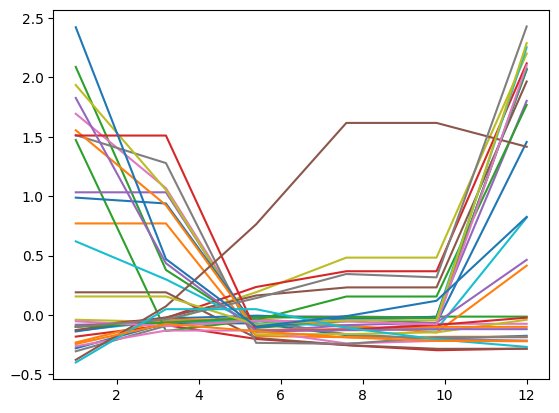

(32,)

In [101]:
grid_convlayer1.plot()
plt.show()


In [142]:
def Hyper_parameter_GridSearch(hyperparams,parameter, grid):
    Total_accuracy_max = torch.tensor([0])
    Optimum_parameter = grid[0]

    
    
    # Obtenir l'attribut correspondant au paramètre spécifié
    attribute = getattr(hyperparams, parameter)
    
    for value in grid:
        # Modifier la valeur de l'attribut de la classe HyperParameters
        setattr(hyperparams, parameter, value)
        
        # Utiliser l'instance de HyperParameters pour effectuer les tests
        _, _, _, _, accuracy,n_best = Hyperparameter_Test(hyperparameters=hyperparams)
        Total_accuracy_max = torch.cat([Total_accuracy_max, torch.tensor([torch.max(accuracy)])])

    Optimum_parameter = grid[torch.argmax(Total_accuracy_max[1:])]
    return Optimum_parameter, torch.max(Total_accuracy_max[1:]),n_best



In [144]:
hyperparameters_opt=Defaults_arguments

In [145]:
param_opt,Max_acc,n_best=Hyper_parameter_GridSearch(hyperparameters_opt,grid = (32,64,128,256),parameter="n_Flat_out")

100%|██████████| 25/25 [00:00<00:00, 60.93it/s]


Précision moyenne = 84.64865 %
Précision max= 91.8919 %
Variance des précisions = 29.656698


100%|██████████| 25/25 [00:00<00:00, 106.40it/s]


Précision moyenne = 84.97297 %
Précision max= 91.8919 %
Variance des précisions = 15.266617


100%|██████████| 25/25 [00:00<00:00, 115.64it/s]


Précision moyenne = 91.24324 %
Précision max= 97.2973 %
Variance des précisions = 9.909923


100%|██████████| 25/25 [00:00<00:00, 111.45it/s]


Précision moyenne = 93.08109 %
Précision max= 97.2973 %
Variance des précisions = 8.570731


In [146]:
param_opt,Max_acc,n_best

(128, tensor(97.2973), tensor(11))

In [147]:
grids = {
    "n_epochs": 25,
    "basis": B(knots=linspace(1,T,6),order=3),
    "granulation": 2000,
    "n_conv_in": (32,64, 128,256),
    "n_conv_in2": (32,64, 128,256),
    "n_conv_in3": (32,64, 128,256),
    "n_Flat_out": (32,64, 128,256),
    "stride_1": (1,2),
    "stride_2": 1,
    "stride_3": 1,
    "stride_pool_1": 2,
    "stride_pool_2": 2,
    "stride_pool_3": 1,
    "kernel_size_1": (3,4,5),
    "kernel_size_2": (3,4,5),
    "kernel_size_3": (3,4,5),
    "kernel_size_pool_1": np.arange(3)[2:],
    "kernel_size_pool_2": np.arange(3)[2:],
    "kernel_size_pool_3": (2,3),
    "dilation_1": 1,
    "dilation_2": 1,
    "dilation_3": 1,
    "dilation_pool_1": 1,
    "dilation_pool_2": 1,
    "dilation_pool_3": 1,
    "padding_1": np.arange(10)[1:],
    "padding_2": np.arange(10)[1:],
    "padding_3": np.arange(10)[1:],
    "padding_pool_1": np.arange(4)[1:],
    "padding_pool_2": np.arange(4)[1:],
    "padding_pool_3": np.arange(4)[1:],
    "opt": "Adam",
    "lr": (0.00089,0.0001,0.00007),
    "loss": nn.CrossEntropyLoss()
}


In [148]:
param_list=["stride_1","kernel_size_1","kernel_size_3","kernel_size_pool_1","kernel_size_pool_2","kernel_size_3","n_conv_in","n_conv_in2","n_conv_in3","n_Flat_out","lr"]

In [279]:
def Hyperparameter_Search(hyperparams, grids, parameters):
    best_parameters = HyperParameters()
    best_accuracy = 0.0
    mean_acc_base=0.0
    var_acc=0.0
    i=1
    # Boucle sur les paramètres
    for param in parameters:
        # Vérifier si le paramètre est dans la grille
        if param in grids:
            grid_values = grids[param]  # Récupérer les valeurs de la grille pour le paramètre donné

            # Boucle sur les valeurs de la grille pour le paramètre
            for value in grid_values:
                # Mettre à jour les hyperparamètres avec la valeur actuelle du paramètre
                setattr(hyperparams, param, value)

                # Appeler la fonction de Grid Search avec les paramètres spécifiés
                optimum_parameter, total_accuracy,n_best = Hyper_parameter_GridSearch(hyperparams,grid=grid_values,parameter=param)
                Mean_acc=((torch.mean(total_accuracy.float()))).detach().cpu().numpy()
                Max_acc=((torch.max(total_accuracy.float()))).detach().cpu().numpy()
                Var_acc=((torch.var(total_accuracy.float()))).detach().cpu().numpy()
            
                # Mettre à jour le meilleur résultat si nécessaire
                if total_accuracy >= best_accuracy:
                    if total_accuracy==best_accuracy:
                        if var_acc>Var_acc:
                            best_parameters.param = optimum_parameter
                            best_accuracy = total_accuracy
                    else:
                        best_parameters.param = optimum_parameter
                        best_accuracy = total_accuracy
                    i+=1
    return best_parameters, best_accuracy,n_best,i


In [280]:
Defaults_arguments=HyperParameters()

In [281]:
best_para,best_acc,n_best,combien=Hyperparameter_Search(hyperparams=Defaults_arguments,grids=grids,parameters=param_list)

100%|██████████| 25/25 [00:00<00:00, 72.86it/s]


Précision moyenne = 90.48648 %
Précision max= 94.5946 %
Variance des précisions = 5.551509


100%|██████████| 25/25 [00:00<00:00, 113.97it/s]


Précision moyenne = 93.837845 %
Précision max= 97.2973 %
Variance des précisions = 11.882159


100%|██████████| 25/25 [00:00<00:00, 115.09it/s]


Précision moyenne = 95.56758 %
Précision max= 97.2973 %
Variance des précisions = 3.579255


100%|██████████| 25/25 [00:00<00:00, 115.30it/s]


Précision moyenne = 86.27027 %
Précision max= 91.8919 %
Variance des précisions = 12.734353


100%|██████████| 25/25 [00:00<00:00, 116.86it/s]


Précision moyenne = 83.89189 %
Précision max= 97.2973 %
Variance des précisions = 39.858784


100%|██████████| 25/25 [00:00<00:00, 111.53it/s]


Précision moyenne = 89.51352 %
Précision max= 94.5946 %
Variance des précisions = 25.760904


100%|██████████| 25/25 [00:00<00:00, 119.99it/s]


Précision moyenne = 95.89189 %
Précision max= 97.2973 %
Variance des précisions = 5.551501


100%|██████████| 25/25 [00:00<00:00, 119.38it/s]


Précision moyenne = 84.432434 %
Précision max= 89.189186 %
Variance des précisions = 28.78012


100%|██████████| 25/25 [00:00<00:00, 120.05it/s]


Précision moyenne = 89.189186 %
Précision max= 94.5946 %
Variance des précisions = 39.56662


100%|██████████| 25/25 [00:00<00:00, 121.47it/s]


Précision moyenne = 81.62162 %
Précision max= 91.8919 %
Variance des précisions = 28.609694


100%|██████████| 25/25 [00:00<00:00, 119.40it/s]


Précision moyenne = 81.40541 %
Précision max= 86.48649 %
Variance des précisions = 31.23936


100%|██████████| 25/25 [00:00<00:00, 120.56it/s]


Précision moyenne = 78.48649 %
Précision max= 89.189186 %
Variance des précisions = 34.380325


100%|██████████| 25/25 [00:00<00:00, 119.74it/s]


Précision moyenne = 85.62162 %
Précision max= 91.8919 %
Variance des précisions = 10.177745


100%|██████████| 25/25 [00:00<00:00, 100.66it/s]


Précision moyenne = 94.054054 %
Précision max= 97.2973 %
Variance des précisions = 17.6528


100%|██████████| 25/25 [00:00<00:00, 113.09it/s]


Précision moyenne = 93.945946 %
Précision max= 97.2973 %
Variance des précisions = 5.648897


100%|██████████| 25/25 [00:00<00:00, 116.10it/s]


Précision moyenne = 95.78379 %
Précision max= 100.0 %
Variance des précisions = 22.57121


100%|██████████| 25/25 [00:00<00:00, 117.83it/s]


Précision moyenne = 89.837845 %
Précision max= 94.5946 %
Variance des précisions = 13.562229


100%|██████████| 25/25 [00:00<00:00, 112.76it/s]


Précision moyenne = 90.702705 %
Précision max= 94.5946 %
Variance des précisions = 26.832235


100%|██████████| 25/25 [00:00<00:00, 118.77it/s]


Précision moyenne = 93.945946 %
Précision max= 100.0 %
Variance des précisions = 21.475534


100%|██████████| 25/25 [00:00<00:00, 120.54it/s]


Précision moyenne = 87.24324 %
Précision max= 94.5946 %
Variance des précisions = 24.665222


100%|██████████| 25/25 [00:00<00:00, 110.53it/s]


Précision moyenne = 85.72974 %
Précision max= 94.5946 %
Variance des précisions = 52.057484


100%|██████████| 25/25 [00:00<00:00, 107.36it/s]


Précision moyenne = 80.21622 %
Précision max= 89.189186 %
Variance des précisions = 54.00536


100%|██████████| 25/25 [00:00<00:00, 103.88it/s]


Précision moyenne = 92.54055 %
Précision max= 97.2973 %
Variance des précisions = 17.82323


100%|██████████| 25/25 [00:00<00:00, 108.85it/s]


Précision moyenne = 85.837845 %
Précision max= 94.5946 %
Variance des précisions = 25.127844


100%|██████████| 25/25 [00:00<00:00, 110.54it/s]


Précision moyenne = 89.837845 %
Précision max= 94.5946 %
Variance des précisions = 25.127851


100%|██████████| 25/25 [00:00<00:00, 125.00it/s]


Précision moyenne = 84.64865 %
Précision max= 91.8919 %
Variance des précisions = 10.7864685


100%|██████████| 25/25 [00:00<00:00, 107.66it/s]


Précision moyenne = 83.02703 %
Précision max= 94.5946 %
Variance des précisions = 31.96981


100%|██████████| 25/25 [00:00<00:00, 118.50it/s]


Précision moyenne = 82.59459 %
Précision max= 91.8919 %
Variance des précisions = 26.223534


100%|██████████| 25/25 [00:00<00:00, 116.22it/s]


Précision moyenne = 89.40541 %
Précision max= 94.5946 %
Variance des précisions = 25.51742


100%|██████████| 25/25 [00:00<00:00, 115.52it/s]


Précision moyenne = 93.72973 %
Précision max= 100.0 %
Variance des précisions = 28.439247


100%|██████████| 25/25 [00:00<00:00, 122.28it/s]


Précision moyenne = 91.67568 %
Précision max= 100.0 %
Variance des précisions = 79.69322


100%|██████████| 25/25 [00:00<00:00, 119.07it/s]


Précision moyenne = 90.16217 %
Précision max= 97.2973 %
Variance des précisions = 28.536663


100%|██████████| 25/25 [00:00<00:00, 120.77it/s]


Précision moyenne = 92.54055 %
Précision max= 97.2973 %
Variance des précisions = 10.518635


100%|██████████| 25/25 [00:00<00:00, 124.18it/s]


Précision moyenne = 99.02703 %
Précision max= 100.0 %
Variance des précisions = 2.3618155


100%|██████████| 25/25 [00:00<00:00, 123.58it/s]


Précision moyenne = 89.081085 %
Précision max= 94.5946 %
Variance des précisions = 25.858307


100%|██████████| 25/25 [00:00<00:00, 124.18it/s]


Précision moyenne = 93.08109 %
Précision max= 97.2973 %
Variance des précisions = 13.440484


100%|██████████| 25/25 [00:00<00:00, 122.85it/s]


Précision moyenne = 93.72971 %
Précision max= 100.0 %
Variance des précisions = 32.70027


100%|██████████| 25/25 [00:00<00:00, 120.55it/s]


Précision moyenne = 93.08109 %
Précision max= 100.0 %
Variance des précisions = 23.17993


100%|██████████| 25/25 [00:00<00:00, 112.99it/s]


Précision moyenne = 90.054054 %
Précision max= 97.2973 %
Variance des précisions = 31.48285


100%|██████████| 25/25 [00:00<00:00, 121.73it/s]


Précision moyenne = 95.567566 %
Précision max= 100.0 %
Variance des précisions = 8.448994


100%|██████████| 25/25 [00:00<00:00, 123.55it/s]


Précision moyenne = 74.054054 %
Précision max= 91.8919 %
Variance des précisions = 44.436333


100%|██████████| 25/25 [00:00<00:00, 120.54it/s]


Précision moyenne = 90.810814 %
Précision max= 100.0 %
Variance des précisions = 17.652796


100%|██████████| 25/25 [00:00<00:00, 116.09it/s]


Précision moyenne = 89.4054 %
Précision max= 91.8919 %
Variance des précisions = 5.429763


100%|██████████| 25/25 [00:00<00:00, 122.90it/s]


Précision moyenne = 93.1892 %
Précision max= 100.0 %
Variance des précisions = 16.508398


100%|██████████| 25/25 [00:00<00:00, 122.84it/s]


Précision moyenne = 91.459465 %
Précision max= 97.2973 %
Variance des précisions = 44.241554


100%|██████████| 25/25 [00:00<00:00, 123.48it/s]


Précision moyenne = 96.21622 %
Précision max= 100.0 %
Variance des précisions = 56.00195


100%|██████████| 25/25 [00:00<00:00, 123.40it/s]


Précision moyenne = 94.918915 %
Précision max= 100.0 %
Variance des précisions = 27.587044


100%|██████████| 25/25 [00:00<00:00, 123.95it/s]


Précision moyenne = 83.89189 %
Précision max= 97.2973 %
Variance des précisions = 45.337246


100%|██████████| 25/25 [00:00<00:00, 118.85it/s]


Précision moyenne = 95.67568 %
Précision max= 100.0 %
Variance des précisions = 11.5656185


100%|██████████| 25/25 [00:00<00:00, 122.59it/s]


Précision moyenne = 96.32433 %
Précision max= 100.0 %
Variance des précisions = 6.0141253


100%|██████████| 25/25 [00:00<00:00, 120.01it/s]


Précision moyenne = 88.86486 %
Précision max= 97.2973 %
Variance des précisions = 22.108597


100%|██████████| 25/25 [00:00<00:00, 109.52it/s]


Précision moyenne = 91.24324 %
Précision max= 97.2973 %
Variance des précisions = 48.8678


100%|██████████| 25/25 [00:00<00:00, 123.41it/s]


Précision moyenne = 93.189186 %
Précision max= 97.2973 %
Variance des précisions = 12.247387


100%|██████████| 25/25 [00:00<00:00, 106.30it/s]


Précision moyenne = 84.64866 %
Précision max= 94.5946 %
Variance des précisions = 60.092537


100%|██████████| 25/25 [00:00<00:00, 100.22it/s]


Précision moyenne = 93.51352 %
Précision max= 100.0 %
Variance des précisions = 33.47944


100%|██████████| 25/25 [00:00<00:00, 116.32it/s]


Précision moyenne = 85.62162 %
Précision max= 94.5946 %
Variance des précisions = 23.569529


100%|██████████| 25/25 [00:00<00:00, 120.20it/s]


Précision moyenne = 92.97297 %
Précision max= 100.0 %
Variance des précisions = 34.696865


100%|██████████| 25/25 [00:00<00:00, 97.75it/s] 


Précision moyenne = 76.21622 %
Précision max= 91.8919 %
Variance des précisions = 72.437325


100%|██████████| 25/25 [00:00<00:00, 96.10it/s] 


Précision moyenne = 94.70271 %
Précision max= 97.2973 %
Variance des précisions = 16.727537


100%|██████████| 25/25 [00:00<00:00, 98.24it/s] 


Précision moyenne = 93.72973 %
Précision max= 100.0 %
Variance des précisions = 36.961292


100%|██████████| 25/25 [00:00<00:00, 102.49it/s]


Précision moyenne = 93.51352 %
Précision max= 97.2973 %
Variance des précisions = 6.0871677


100%|██████████| 25/25 [00:00<00:00, 113.42it/s]


Précision moyenne = 78.48648 %
Précision max= 86.48649 %
Variance des précisions = 41.07623


100%|██████████| 25/25 [00:00<00:00, 103.50it/s]


Précision moyenne = 84.97298 %
Précision max= 94.5946 %
Variance des précisions = 57.876793


100%|██████████| 25/25 [00:00<00:00, 110.09it/s]


Précision moyenne = 87.135124 %
Précision max= 94.5946 %
Variance des précisions = 33.649868


100%|██████████| 25/25 [00:00<00:00, 116.56it/s]


Précision moyenne = 92.540535 %
Précision max= 97.2973 %
Variance des précisions = 8.083765


100%|██████████| 25/25 [00:00<00:00, 119.42it/s]


Précision moyenne = 88.10811 %
Précision max= 97.2973 %
Variance des précisions = 112.00391


100%|██████████| 25/25 [00:00<00:00, 119.45it/s]


Précision moyenne = 87.45945 %
Précision max= 97.2973 %
Variance des précisions = 21.84077


100%|██████████| 25/25 [00:00<00:00, 107.79it/s]


Précision moyenne = 84.540535 %
Précision max= 94.5946 %
Variance des précisions = 55.10106


100%|██████████| 25/25 [00:00<00:00, 117.74it/s]


Précision moyenne = 86.702705 %
Précision max= 97.2973 %
Variance des précisions = 35.8656


100%|██████████| 25/25 [00:00<00:00, 120.63it/s]


Précision moyenne = 92.54055 %
Précision max= 100.0 %
Variance des précisions = 28.780146


100%|██████████| 25/25 [00:00<00:00, 91.10it/s] 


Précision moyenne = 70.054054 %
Précision max= 78.37838 %
Variance des précisions = 27.952272


100%|██████████| 25/25 [00:00<00:00, 104.26it/s]


Précision moyenne = 91.567566 %
Précision max= 97.2973 %
Variance des précisions = 16.630152


100%|██████████| 25/25 [00:00<00:00, 114.60it/s]


Précision moyenne = 93.1892 %
Précision max= 100.0 %
Variance des précisions = 34.161217


100%|██████████| 25/25 [00:00<00:00, 111.05it/s]


Précision moyenne = 89.40541 %
Précision max= 100.0 %
Variance des précisions = 92.476265


100%|██████████| 25/25 [00:00<00:00, 121.22it/s]


Précision moyenne = 88.21622 %
Précision max= 94.5946 %
Variance des précisions = 21.232063


100%|██████████| 25/25 [00:00<00:00, 110.48it/s]


Précision moyenne = 85.72973 %
Précision max= 94.5946 %
Variance des précisions = 56.3185


100%|██████████| 25/25 [00:00<00:00, 123.79it/s]


Précision moyenne = 92.21622 %
Précision max= 100.0 %
Variance des précisions = 23.934753


100%|██████████| 25/25 [00:00<00:00, 111.48it/s]


Précision moyenne = 86.05406 %
Précision max= 94.5946 %
Variance des précisions = 56.415874


100%|██████████| 25/25 [00:00<00:00, 121.18it/s]


Précision moyenne = 91.459465 %
Précision max= 100.0 %
Variance des précisions = 25.371315


100%|██████████| 25/25 [00:00<00:00, 111.81it/s]


Précision moyenne = 87.675674 %
Précision max= 100.0 %
Variance des précisions = 28.049677


100%|██████████| 25/25 [00:00<00:00, 111.86it/s]


Précision moyenne = 85.62162 %
Précision max= 91.8919 %
Variance des précisions = 42.439743


100%|██████████| 25/25 [00:00<00:00, 121.13it/s]


Précision moyenne = 93.189186 %
Précision max= 100.0 %
Variance des précisions = 45.11809


100%|██████████| 25/25 [00:00<00:00, 122.38it/s]


Précision moyenne = 84.75676 %
Précision max= 94.5946 %
Variance des précisions = 26.710505


100%|██████████| 25/25 [00:00<00:00, 123.88it/s]


Précision moyenne = 89.081085 %
Précision max= 94.5946 %
Variance des précisions = 29.510609


100%|██████████| 25/25 [00:00<00:00, 124.13it/s]


Précision moyenne = 88.10811 %
Précision max= 97.2973 %
Variance des précisions = 39.566605


100%|██████████| 25/25 [00:00<00:00, 126.02it/s]


Précision moyenne = 85.081085 %
Précision max= 91.8919 %
Variance des précisions = 34.769897


100%|██████████| 25/25 [00:00<00:00, 124.05it/s]


Précision moyenne = 88.10811 %
Précision max= 94.5946 %
Variance des précisions = 7.3045974


100%|██████████| 25/25 [00:00<00:00, 121.69it/s]


Précision moyenne = 84.10811 %
Précision max= 91.8919 %
Variance des précisions = 41.587555


100%|██████████| 25/25 [00:00<00:00, 113.88it/s]


Précision moyenne = 89.51352 %
Précision max= 94.5946 %
Variance des précisions = 17.847588


100%|██████████| 25/25 [00:00<00:00, 122.31it/s]


Précision moyenne = 91.67568 %
Précision max= 100.0 %
Variance des précisions = 43.170216


100%|██████████| 25/25 [00:00<00:00, 123.46it/s]


Précision moyenne = 86.16217 %
Précision max= 91.8919 %
Variance des précisions = 16.021433


100%|██████████| 25/25 [00:00<00:00, 123.45it/s]


Précision moyenne = 87.675674 %
Précision max= 94.5946 %
Variance des précisions = 31.701979


100%|██████████| 25/25 [00:00<00:00, 113.50it/s]


Précision moyenne = 88.864876 %
Précision max= 97.2973 %
Variance des précisions = 62.28393


100%|██████████| 25/25 [00:00<00:00, 121.08it/s]


Précision moyenne = 88.324326 %
Précision max= 94.5946 %
Variance des précisions = 8.960314


100%|██████████| 25/25 [00:00<00:00, 117.67it/s]


Précision moyenne = 87.13515 %
Précision max= 94.5946 %
Variance des précisions = 44.606792


100%|██████████| 25/25 [00:00<00:00, 121.22it/s]


Précision moyenne = 91.78379 %
Précision max= 100.0 %
Variance des précisions = 9.422937


100%|██████████| 25/25 [00:00<00:00, 123.58it/s]


Précision moyenne = 96.324326 %
Précision max= 100.0 %
Variance des précisions = 13.9274435


100%|██████████| 25/25 [00:00<00:00, 123.57it/s]


Précision moyenne = 96.00001 %
Précision max= 100.0 %
Variance des précisions = 8.595078


100%|██████████| 25/25 [00:00<00:00, 119.36it/s]


Précision moyenne = 97.40541 %
Précision max= 100.0 %
Variance des précisions = 13.683943


100%|██████████| 25/25 [00:00<00:00, 120.73it/s]


Précision moyenne = 90.486496 %
Précision max= 94.5946 %
Variance des précisions = 14.073541


100%|██████████| 25/25 [00:00<00:00, 111.53it/s]


Précision moyenne = 83.459465 %
Précision max= 94.5946 %
Variance des précisions = 46.457294


100%|██████████| 25/25 [00:00<00:00, 122.39it/s]


Précision moyenne = 82.7027 %
Précision max= 94.5946 %
Variance des précisions = 52.95837


100%|██████████| 25/25 [00:00<00:00, 122.97it/s]


Précision moyenne = 92.75676 %
Précision max= 97.2973 %
Variance des précisions = 7.7428885


100%|██████████| 25/25 [00:00<00:00, 122.88it/s]


Précision moyenne = 71.24325 %
Précision max= 83.78379 %
Variance des précisions = 40.71098


100%|██████████| 25/25 [00:00<00:00, 122.37it/s]


Précision moyenne = 74.054054 %
Précision max= 83.78379 %
Variance des précisions = 36.523


100%|██████████| 25/25 [00:00<00:00, 121.75it/s]


Précision moyenne = 89.40541 %
Précision max= 94.5946 %
Variance des précisions = 39.51791


In [291]:

model_opt,_,_,_,Qcc,n_best=Hyperparameter_Test(hyperparameters=best_para)


100%|██████████| 25/25 [00:00<00:00, 77.99it/s]


Précision moyenne = 92.864876 %
Précision max= 100.0 %
Variance des précisions = 24.275625


tensor([ 83.7838,  89.1892,  86.4865,  86.4865,  89.1892,  83.7838,  91.8919,
         89.1892,  91.8919,  94.5946,  94.5946,  94.5946,  94.5946, 100.0000,
        100.0000,  86.4865,  94.5946,  91.8919,  97.2973,  94.5946, 100.0000,
         97.2973,  97.2973,  94.5946,  97.2973])

Functionnal_conv_classifier(
  (Relu): ReLU()
  (convlayer1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.18)
    (3): Identity()
    (4): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.18)
    (7): Identity()
  )
  (convlayer2): Sequential(
    (0): Conv1d(32, 512, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.18)
    (3): Identity()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.18)
    (7): I

In [278]:
train_fn = Compile_train(module=model_opt, lr=lr_adam, opt="Adam", loss=loss_function, batch_size=batch_size)
train_fn(n_epochs=1)
mean_accuracy=torch.tensor([0])
for i in tqdm(range(best_para.n_epochs)):
        train_fn(n_epochs=1)
        
        accuracy=((torch.sum(torch.argmax(model_opt(x_test),dim=1)==y_test)/x_test.shape[0])*100)
        mean_accuracy=torch.cat([mean_accuracy,accuracy.cpu().unsqueeze(0)],dim=0)
Mean_acc=((torch.mean(mean_accuracy[1:].float()))).detach().cpu().numpy()
Max_acc=((torch.max(mean_accuracy[1:].float()))).detach().cpu().numpy()
Var_acc=((torch.var(mean_accuracy[1:].float()))).detach().cpu().numpy()
print("Précision moyenne =",Mean_acc,"%")  
print("Précision max=",Max_acc,"%")  
print("Variance des précisions =",Var_acc)  



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 95.87it/s]

Précision moyenne = 78.10811 %
Précision max= 86.48649 %
Variance des précisions = 4.795953


In [294]:
accuracy=((torch.sum(torch.argmax(model_opt(x_test),dim=1)==y_test)/x_test.shape[0])*100)
accuracy

tensor(67.5676, device='cuda:0')

In [190]:
import gc
torch.cuda.empty_cache()
gc.collect()

0